## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Разработчик: Тимур С.**

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

**Подключение библиотек и скриптов**

In [1]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [2]:
import numpy as np
import pandas as pd
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

d:\Users\Tim\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
d:\Users\Tim\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


**Пути к директориям и файлам**

In [3]:
# input
TRAIN_DATASET_PATH = '../course_project_train.csv'
TEST_DATASET_PATH = '../course_project_test.csv'
TRAIN_FULL_PATH = '../training_project_train_full.csv'
TRAIN_PART_PATH = '../training_project_train_part_b.csv'
TEST_PART_PATH = '../training_project_test_part.csv'

# output
PREP_DATASET_PATH = '../training_project_data_prep.csv'
SCALER_FILE_PATH = '../scaler.pkl'
MODEL_FILE_PATH = '../model.pkl'

## Построение модели классификации

### 1. Обзор обучающего датасета

**Загрузка данных**

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
df_train.shape

(7500, 17)

In [6]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [7]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

В колонках Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score имеются пропуски.
Их нужно будет некоторым образом обработать.

### Приведение типов

Узнаем, какое количество разнообразных значений содержится в каждом из столбцов.

In [9]:
for colname in df_train.columns:
    print(str(colname) + ' (diversity: ' + str(len(df_train[colname].value_counts())) + ') \n\n' 
          + str(df_train[colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership (diversity: 4) 

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Annual Income (diversity: 5478) 

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
851751.0     3
1160862.0    3
1071125.0    3
939170.0     3
1496288.0    3
868490.0     3
713127.0     3
1431840.0    3
750880.0     3
741760.0     3
2293908.0    3
869877.0     3
1547512.0    3
1037894.0    3
1508600.0    3
1405335.0    3
1068313.0    3
1912920.0    3
1297814.0    3
1458915.0    3
745864.0     3
1258712.0    3
749816.0     3
465405.0     3
1206348.0    3
            ..
1206842.0    1
1671905.0    1
1766468.0    1
1380198.0    1
742691.0     1
2069309.0    1
2387293.0    1
1649238.0    1
1796697.0    1
1174048.0    1
1500696.0    1
2980644.0    1
1272316.0    1
767220.0     1
1567215.0    1
2239644.0    1
1092

К номинативным (категориальным) признакам можно отнести столбцы: Home Ownership (4), Years in current job (11), Tax Liens (8), 
Number of Credit Problems (8), Bankruptcies (5), Purpose (15), Term (2).

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [10]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent',
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']

In [11]:
def convert_types(df):
    for colname in CAT_FEATURE_NAMES:
        df[colname] = df[colname].astype(str)
    return df

In [12]:
df_train = convert_types(df_train)
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                        object
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems        object
Months since last delinquent    float64
Bankruptcies                     object
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [13]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,nan,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Обзор количественных признаков**

In [14]:
df_train.describe()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7.500000e+03,3419.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,11.130933,18.317467,9.451537e+05,34.692600,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,4.908924,7.041946,1.602622e+07,21.688806,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,2.000000,4.000000,0.000000e+00,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,8.000000,13.500000,2.792295e+05,16.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,10.000000,17.000000,4.781590e+05,32.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,14.000000,21.800000,7.935015e+05,50.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,43.000000,57.700000,1.304726e+09,118.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обзор номинативных признаков**

In [15]:
for colname in df_train.select_dtypes(include='object').columns:
    print(str(colname) + '\n\n' + str(df_train[colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of 

**Загрузка тестовых данных**

In [16]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [17]:
df_test.shape

(2500, 16)

### 2. Обработка выбросов

### 3. Обработка пропусков

Пропуски в столбце Years in current job заполним пропуски наиболее типичным значением признака.

В целях тестирования, можно раскомментировать код и заполнить пропуски значением 'unknown years', которые будут учитываться моделью как отдельные значения признака.

In [18]:
def process_Years_in_current_job(df):
    #typical_val = 'unknown years' 
    typical_val = df['Years in current job'].mode()[0]
    df.loc[df['Years in current job'] == 'nan', 'Years in current job'] = typical_val
    return df

In [19]:
df_train = process_Years_in_current_job(df_train)
df_train['Years in current job'].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Заполним пропуски в столбце Bankruptcies. 

Для заполнения пропусков в Bankruptcies можно воспользоваться одной из двух стратегий:

1) заполнить пропуски наиболее часто встречающимся значением признака; 

2) оставить пропуски как есть, далее они будут преобразованы в строковое значение 'nan' и будут учитываться моделью как отдельные значения признака. 

В данном случае воспользуемся первой стратегией, т.к. наиболее типичное для данного признака значение является в выборке явно преобладающим.

In [20]:
def process_Bankruptcies(df):
    typical_val = df['Bankruptcies'].mode()[0]
    df.loc[df['Bankruptcies'] == 'nan', 'Bankruptcies'] = typical_val
    return df

In [21]:
df_train = process_Bankruptcies(df_train)
df_train['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

Посмотрим, какие еще столбцы содержат пропуски данных.

In [22]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [23]:
def process_Annual_Income(df):
    """Метод обработки пропусков в столбце Annual Income"""
    mean_val = 0.0 # df['Annual Income'].median()
    df['Annual Income'] = df['Annual Income'].fillna(mean_val)
    return df

In [24]:
df_train = process_Annual_Income(df_train)

In [25]:
def process_Months_since_last_delinquent(df):
    """Метод обработки пропусков в столбце Months since last delinquent
    Для заполнения пропусков можно воспользоваться одной из двух стратегий:
    1. заполнить нулевыми значениями
    2. заполнить средним
    Другими стратегиями могут являться:
    - заполнить наиболее часто встречающимся значением
    - найти зависимость от других факторов и рассчитать значение
    Воспользуемся пока 1-й стратегией
    """
    df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0.0) 
    # mean_val = df['Months since last delinquent'].median()
    # df['Months since last delinquent'] = df['Months since last delinquent'].fillna(mean_val) 
    return df

In [26]:
df_train = process_Months_since_last_delinquent(df_train)

In [27]:
def process_Credit_Score(df):
    """Метод обработки пропусков в столбце Credit Score"""
    mean_val = df['Credit Score'].mean()
    df['Credit Score'] = df['Credit Score'].fillna(mean_val)
    return df

In [28]:
df_train = process_Credit_Score(df_train)

Убедимся, что не осталось столбцов с пропусками

In [29]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### Сохранение обучающего датасета<a class="anchor" id="saving"></a>

In [30]:
df_train.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### 4. Анализ данных

In [31]:
df_base = pd.read_csv(TRAIN_DATASET_PATH)
df = pd.read_csv(PREP_DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Выделение целевой переменной и групп признаков**

In [32]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

**Анализ целевой переменной**

Обзор распределения

In [33]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Выборка в целевой переменной не очень сбалансирована. Значений '0' в 2.5 раза больше, чем значений '1'.

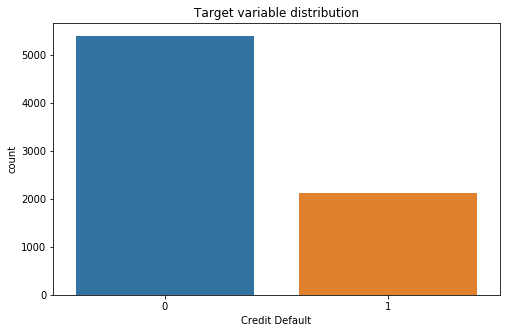

In [34]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

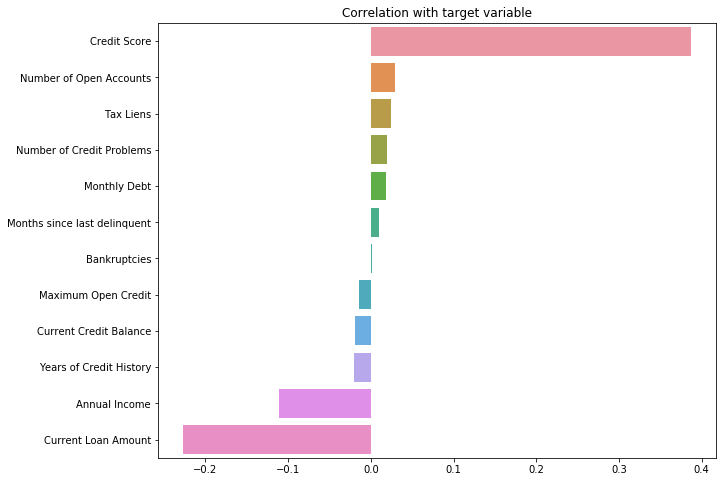

In [35]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Оценка признака "Credit Score" в разрезе целевой переменной**

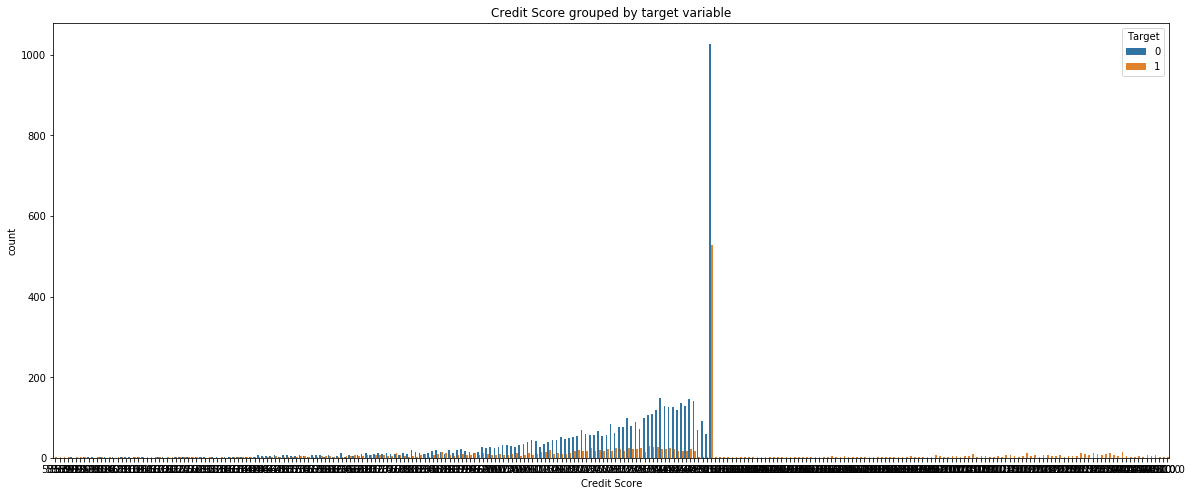

In [36]:
plt.figure(figsize=(20, 8))

sns.countplot(x="Credit Score", hue=TARGET_NAME, data=df)
plt.title('Credit Score grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

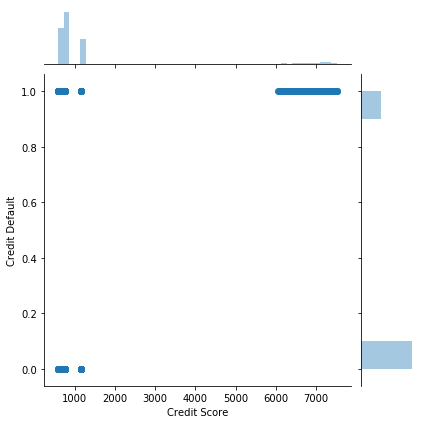

In [37]:
sns.jointplot(df["Credit Score"], df[TARGET_NAME])

*Сформируем выборку и рассчитаем наблюдаемые частоты*

In [38]:
upper_bound = df['Credit Score'].max()
lower_bound = df['Credit Score'].min()

In [39]:
credit_score_and_target_s = df.loc[df['Credit Score'], ['ID', 'Credit Score', 'Credit Default']].sample(1000)

In [40]:
credit_score_and_target_s

,ID,Credit Score,Credit Default
739.000000,NaN,1151.087498,0.0
730.000000,NaN,734.000000,0.0
1151.087498,NaN,NaN,NaN
743.000000,NaN,1151.087498,0.0
733.000000,NaN,699.000000,0.0
746.000000,NaN,733.000000,1.0
664.000000,NaN,714.000000,0.0
746.000000,NaN,733.000000,1.0
1151.087498,NaN,NaN,NaN
732.000000,NaN,751.000000,0.0


In [41]:
table = credit_score_and_target_s.pivot_table(values='ID', index='Credit Score', columns='Credit Default', aggfunc='count')
table

Credit Default,0.0,1.0
Credit Score,,
585.000000,NaN,0.0
593.000000,NaN,0.0
622.000000,NaN,0.0
648.000000,NaN,0.0
651.000000,0.0,NaN
659.000000,NaN,0.0
661.000000,0.0,NaN
664.000000,NaN,0.0
670.000000,0.0,NaN


**Оценка признака "Current Loan Amount" в разрезе целевой переменной**

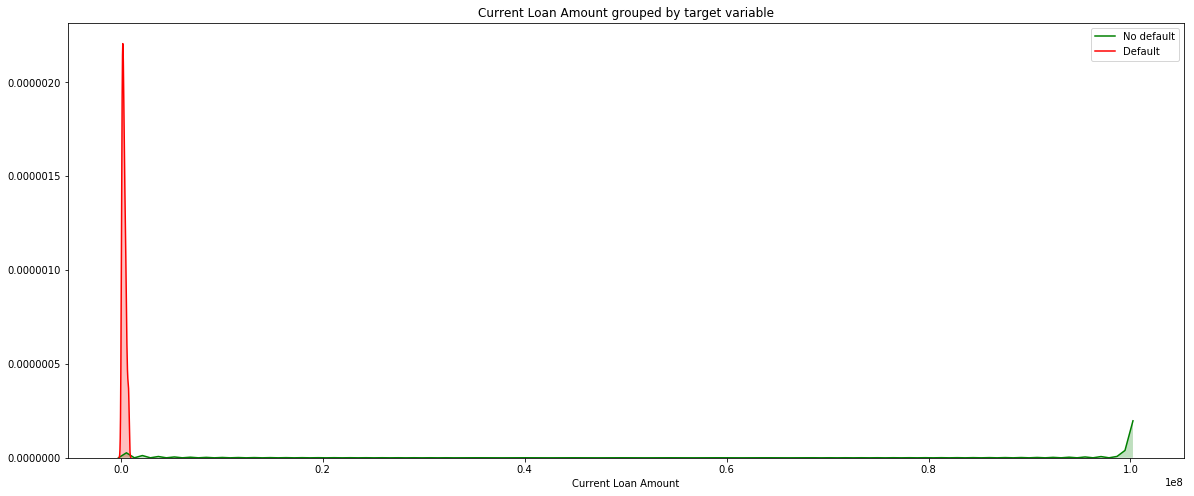

In [42]:
limit_bal_with_target_s = df[['Current Loan Amount', TARGET_NAME]].sample(1000)
limit_bal_s = limit_bal_with_target_s['Current Loan Amount']
limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 0]
limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(20, 8))

sns.kdeplot(limit_bal_target_0, shade=True, label='No default', color='g')
sns.kdeplot(limit_bal_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "LIMIT_BAL" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "LIMIT_BAL" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [43]:
shapiro(limit_bal_s)

(0.37671440839767456, 0.0)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

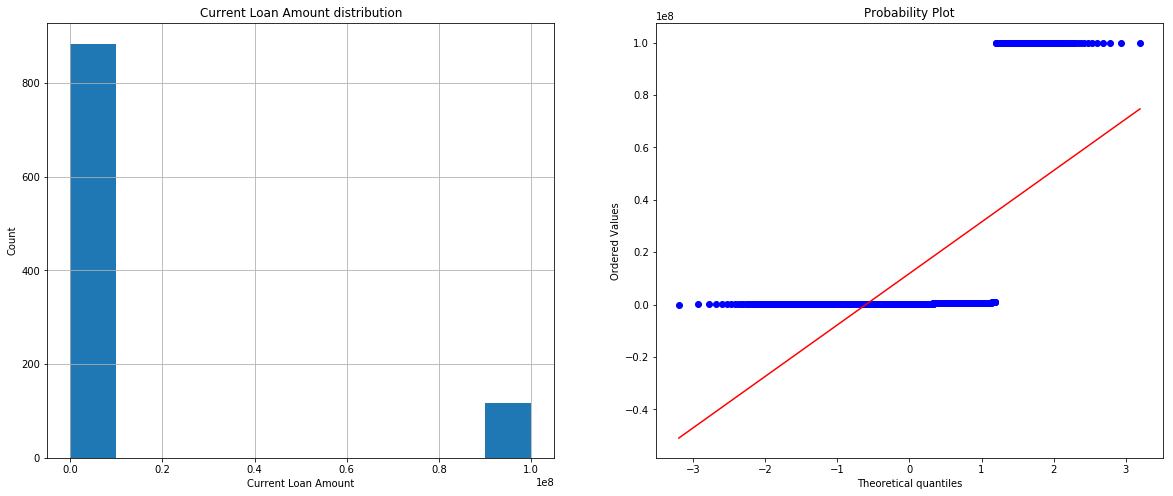

In [44]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
limit_bal_s.hist()

plt.subplot(122)
probplot(limit_bal_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака LIMIT_BAL в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

In [45]:
mannwhitneyu(limit_bal_target_0, limit_bal_target_1)

MannwhitneyuResult(statistic=91008.0, pvalue=0.0019654370498534274)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

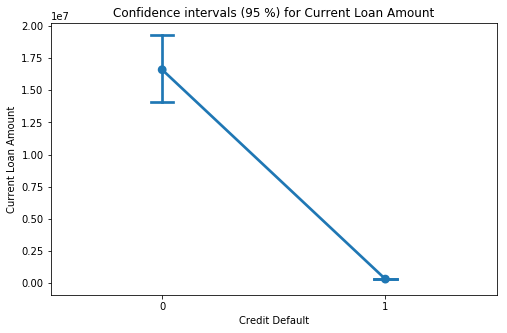

In [46]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=limit_bal_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Анализ признакового пространства<a class="anchor" id="features_analysis"></a>

**Матрица корреляций**

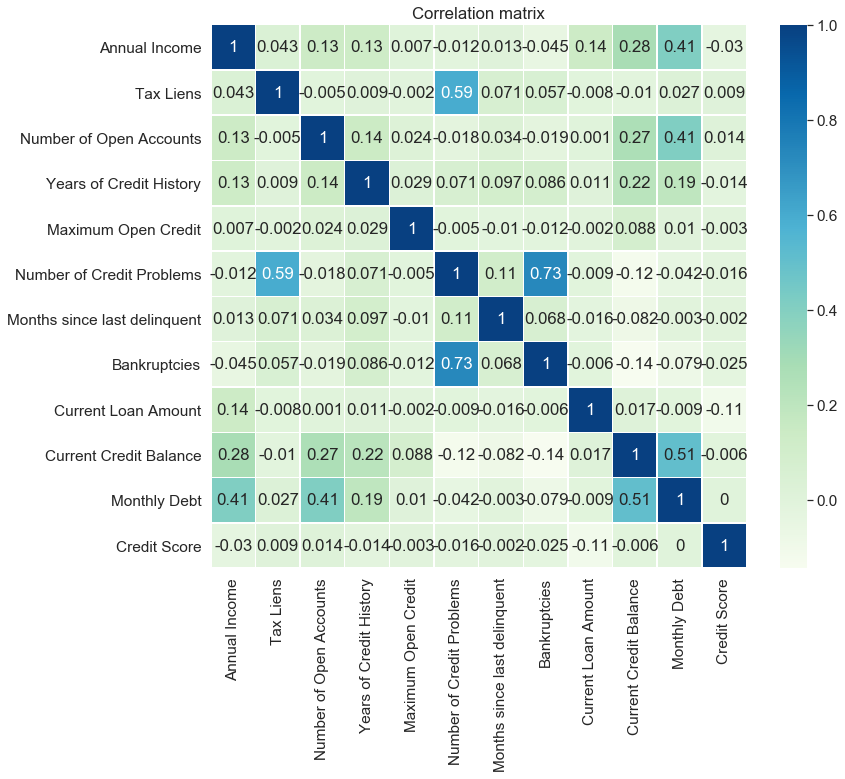

In [47]:
plt.figure(figsize = (12,10))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Теперь посмотрим на распределения всех интересующих нас количественных признаков. На бинарные/категориальные/порядковые признакие будем смотреть отдельно**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000EAFAEB8>,
      dtype=object)

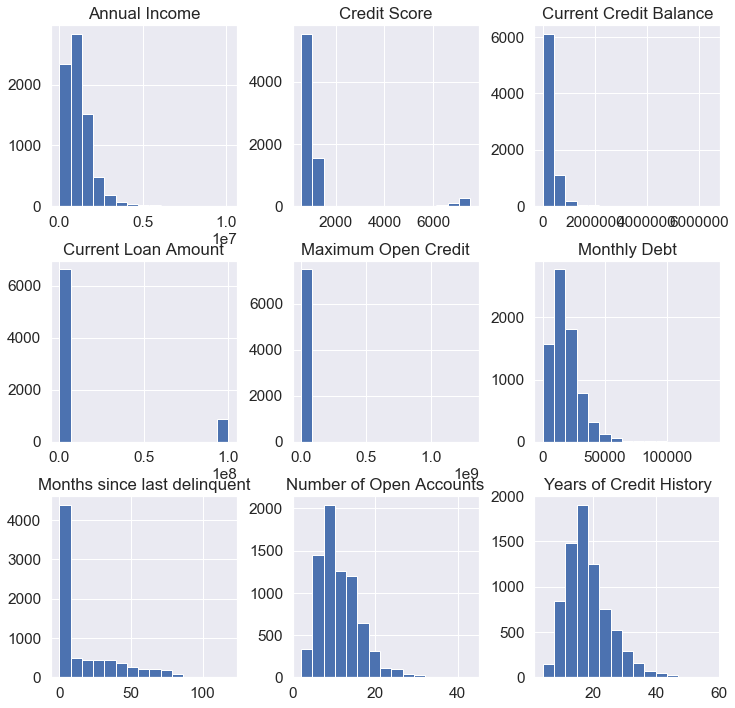

In [48]:
df[NUM_FEATURE_NAMES].hist(figsize=(12,12), bins=15)


Видим, что ни у одного из количественныхпризнаков распределение не близко к нормальному.

Графики большинства признаков больше напоминают распределение Пуассона.

In [49]:
df2 = df
df2[NUM_FEATURE_NAMES] = np.log(df[NUM_FEATURE_NAMES]+0.01)

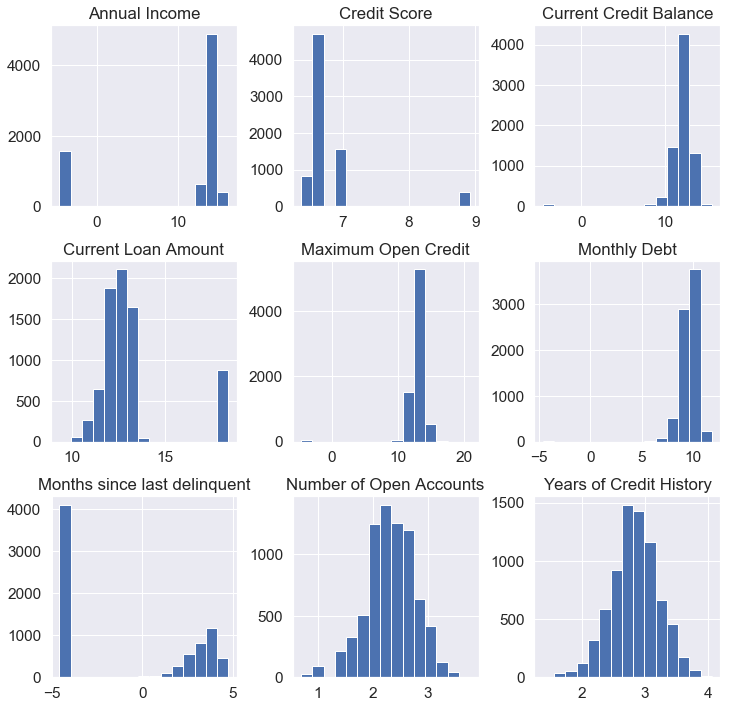

In [50]:
df2[NUM_FEATURE_NAMES].hist(figsize=(12,12), bins=15)
df = df2

После логарифмирования, на нормальное распределение стали похожи признаки 'Number of Open Accounts' и 'Years of Credit History'

In [51]:
def log_columns(num_feature_names, df):
    for column in num_feature_names:
        df[column] = np.log(df[column]+0.01)
    return df

In [52]:
df_train = log_columns(['Annual Income', 'Maximum Open Credit', 'Number of Open Accounts', 'Years of Credit History',], df_train)
#df_train = log_columns(['Annual Income', 'Maximum Open Credit', 'Number of Open Accounts', 'Years of Credit History', 'Credit Score', 'Current Loan Amount'], df_train)

### Lesson 3

In [53]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [54]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### Приведение типов для модели CatBoost

In [55]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership               category
Years in current job         category
Tax Liens                    category
Number of Credit Problems    category
Bankruptcies                 category
Purpose                      category
Term                         category
dtype: object

### Нормализация данных<a class="anchor" id="normalization"></a>

In [56]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

**Сохранение модели для нормализации данных**

In [57]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [58]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [59]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [60]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a> 

In [61]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [62]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [63]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.63      0.85      0.72      3771
           1       0.65      0.37      0.47      2958

   micro avg       0.64      0.64      0.64      6729
   macro avg       0.64      0.61      0.60      6729
weighted avg       0.64      0.64      0.61      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1616
           1       0.48      0.35      0.40       634

   micro avg       0.71      0.71      0.71      2250
   macro avg       0.62      0.60      0.60      2250
weighted avg       0.69      0.71      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1372  244
1                413  221


**k ближайших соседей**

In [64]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      3771
           1       0.79      0.70      0.74      2958

   micro avg       0.79      0.79      0.79      6729
   macro avg       0.79      0.78      0.78      6729
weighted avg       0.79      0.79      0.78      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1616
           1       0.43      0.46      0.44       634

   micro avg       0.67      0.67      0.67      2250
   macro avg       0.60      0.61      0.61      2250
weighted avg       0.68      0.67      0.68      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1220  396
1                340  294


**Бустинговые алгоритмы**

*XGBoost*

In [65]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3771
           1       0.97      0.98      0.97      2958

   micro avg       0.98      0.98      0.98      6729
   macro avg       0.98      0.98      0.98      6729
weighted avg       0.98      0.98      0.98      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1616
           1       0.52      0.45      0.49       634

   micro avg       0.73      0.73      0.73      2250
   macro avg       0.66      0.65      0.65      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1352  264
1                346  288


*LightGBM*

In [66]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3771
           1       0.94      0.88      0.91      2958

   micro avg       0.92      0.92      0.92      6729
   macro avg       0.93      0.92      0.92      6729
weighted avg       0.92      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.84      0.82      1616
           1       0.52      0.44      0.48       634

   micro avg       0.73      0.73      0.73      2250
   macro avg       0.66      0.64      0.65      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1363  253
1                355  279


*CatBoost*

In [67]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3771
           1       0.93      0.84      0.89      2958

   micro avg       0.90      0.90      0.90      6729
   macro avg       0.91      0.90      0.90      6729
weighted avg       0.91      0.90      0.90      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1616
           1       0.54      0.44      0.48       634

   micro avg       0.73      0.73      0.73      2250
   macro avg       0.67      0.65      0.65      2250
weighted avg       0.72      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1374  242
1                355  279


### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [68]:
# model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

**Подбор гиперпараметров**

In [69]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [70]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [71]:
#%%time

# rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs = GridSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)


In [72]:
rs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
       error_score='raise-deprecating',
       estimator=<catboost.core.CatBoostClassifier object at 0x000000000EF81160>,
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200, 500, 700, 1000, 1200, 1500], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [73]:
rs.best_params_

{'max_depth': 7, 'n_estimators': 200}

In [74]:
rs.best_score_

0.4145215447926125

In [75]:
n_estimators = rs.best_params_['n_estimators']
max_depth = rs.best_params_['max_depth']

**Обучение и оценка финальной модели**

In [76]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      3771
           1       0.95      0.88      0.91      2958

   micro avg       0.93      0.93      0.93      6729
   macro avg       0.93      0.92      0.92      6729
weighted avg       0.93      0.93      0.93      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1616
           1       0.54      0.45      0.49       634

   micro avg       0.74      0.74      0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.72      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1373  243
1                351  283
Wall time: 1.6 s


### Lesson 4

In [77]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [78]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [79]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Загрузка подготовленных датасетов<a class="anchor" id="data_loading"></a>

**Загрузка данных**

In [80]:
df = pd.read_csv(TRAIN_FULL_PATH)
df_train = pd.read_csv(TRAIN_PART_PATH)
df_tst = pd.read_csv(TEST_PART_PATH)

**Выделение признакового описания и целевой переменной**

In [81]:
X = df.drop(columns=CAT_FEATURE_NAMES + [TARGET_NAME])
y = df[TARGET_NAME]

X_train = df_train.drop(columns=TARGET_NAME)
y_train = df_train[TARGET_NAME]

X_test = df_tst.drop(columns=TARGET_NAME)
y_test = df_tst[TARGET_NAME]

In [82]:
final_model = catb.CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.94      3771
           1       0.95      0.88      0.91      2958

   micro avg       0.93      0.93      0.93      6729
   macro avg       0.93      0.92      0.92      6729
weighted avg       0.93      0.93      0.93      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1616
           1       0.54      0.45      0.49       634

   micro avg       0.74      0.74      0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.72      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1373  243
1                351  283


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [83]:
final_model = catb.CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      3771
           1       0.83      0.62      0.71      2958

   micro avg       0.78      0.78      0.78      6729
   macro avg       0.79      0.76      0.77      6729
weighted avg       0.79      0.78      0.77      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1616
           1       0.55      0.46      0.50       634

   micro avg       0.74      0.74      0.74      2250
   macro avg       0.68      0.66      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1381  235
1                345  289


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [84]:
final_model = catb.CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=21)

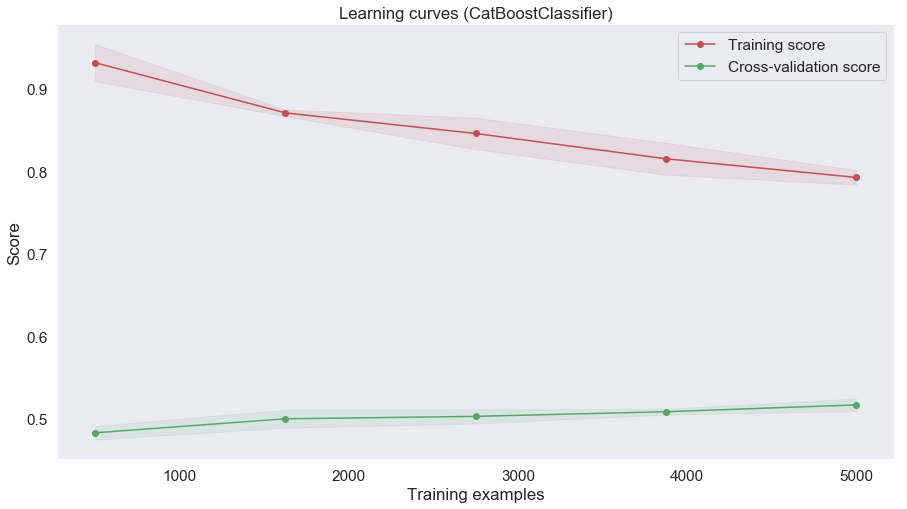

In [85]:
show_learning_curve_plot(final_model, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

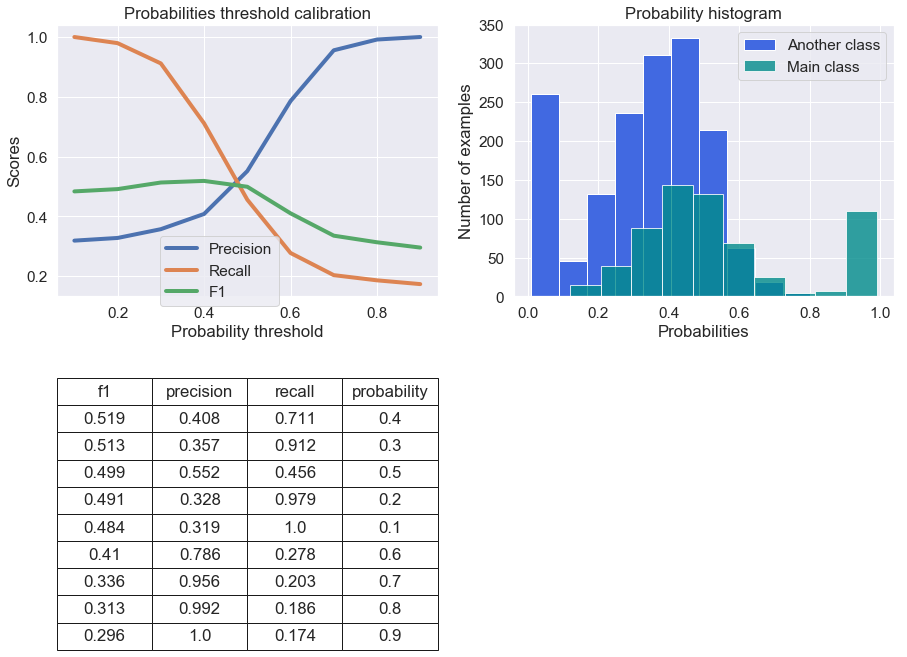

In [86]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

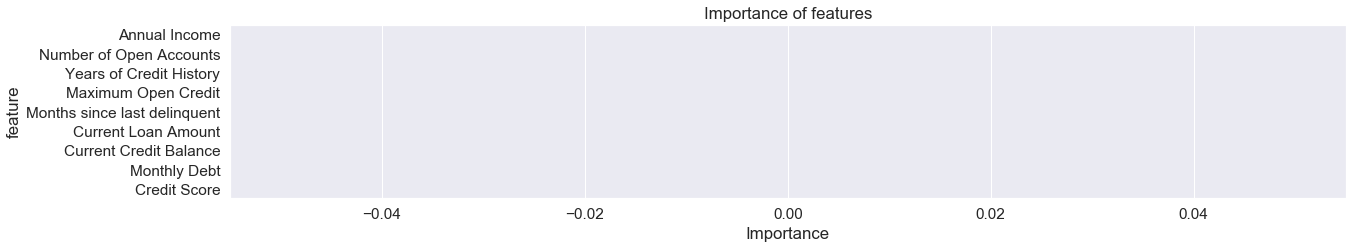

In [87]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [88]:
important_features_top

['Annual Income',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Months since last delinquent',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [89]:
X_train

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Months since last delinquent,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,0.452990,-2.708266,0.351484,-0.073914,1.353640,-0.410485,0.194986,-0.977139,-0.499820
1,-1.949999,0.725389,1.179505,0.256476,0.749673,-0.059909,0.569284,0.232019,0.472963
2,0.584877,0.187360,0.066379,0.502534,-0.901625,-0.116593,0.667273,0.572432,-0.421674
3,0.487535,-0.025245,-0.339724,0.407812,-0.901625,-0.162158,0.739684,-0.267163,-0.356800
4,0.580379,-0.522920,-0.927509,-0.227749,-0.901625,0.217905,-1.932015,0.025559,-0.367032
5,0.519700,-2.708266,-0.617267,-0.130858,-0.901625,2.619995,-0.080161,0.139332,-0.336500
6,-1.949999,0.560044,-0.819986,-0.090338,0.924173,-0.422693,0.095644,-0.788020,0.472963
7,0.413416,-0.260245,1.721734,0.016450,-0.901625,-0.302469,0.215629,-0.703019,-0.771482
8,-1.949999,-2.067787,-1.156678,-9.518148,1.244844,-0.659878,-9.518094,-16.688542,0.472963
9,0.580459,1.023338,1.360652,-0.004437,1.259525,0.038098,0.368265,1.291095,3.918869


### Финальная модель<a class="anchor" id="final_model"></a>

In [90]:
final_model = catb.CatBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      3771
           1       0.83      0.62      0.71      2958

   micro avg       0.78      0.78      0.78      6729
   macro avg       0.79      0.76      0.77      6729
weighted avg       0.79      0.78      0.77      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1616
           1       0.55      0.46      0.50       634

   micro avg       0.74      0.74      0.74      2250
   macro avg       0.68      0.66      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1381  235
1                345  289


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [91]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### 5. Отбор признаков

### 6. Балансировка классов

### 7. Подбор моделей, получение бейзлана

### 8. Выбор наилучшей модели, настройка гиперпараметров

### 9. Проверка качества, борьба с переобучением

### 10. Интерпретация результатов

## Прогнозирование на тестовом датасете

### Выполнить для тестового датасета те же этапы обработки и построения признаков

Обработаем данные в тестовом датасете

In [92]:
df_test = convert_types(df_test)
df_test = process_Years_in_current_job(df_test)
df_test = process_Bankruptcies(df_test)
df_test = process_Annual_Income(df_test)
df_test = process_Months_since_last_delinquent(df_test)
df_test = process_Credit_Score(df_test)
# df_test = log_columns(['Annual Income', 'Maximum Open Credit', 'Number of Open Accounts', 'Years of Credit History', 'Credit Score', 'Current Loan Amount'], df_test)
df_test = log_columns(['Annual Income', 'Maximum Open Credit', 'Number of Open Accounts', 'Years of Credit History',], df_test)

### Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете/
### Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
### Соблюдать исходный порядок примеров из тестового датасета

In [93]:
df_test[TARGET_NAME] = final_model.predict(df_test[important_features_top])

In [100]:
df_norm = df_test.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_test = df_norm.copy()

my_predict = final_model.predict(X_test[important_features_top])
my_predict[20]

1

### Сохранение результата обучения

In [94]:
#Сохраним результат в файл
df_test.loc[:, [TARGET_NAME]].to_csv('TSataev_predictions.csv', index=None)
